# DoorDash Delivery Duration Prediction
The goal is to predict reliable estimate for total delivery time (`actual_delivery_time` - `created_at`)

### Relevant Libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Data Exploration

In [3]:
raw_data = pd.read_csv('../../datasets/doordash_historical_data.csv')
data = raw_data.copy()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [172]:
import datetime
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['actual_total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [173]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [174]:
# new features that are possibly useful
data['estimated_non_prep_duration'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers']

In [175]:
store_id_unique = data['store_id'].unique().tolist()

In [176]:
# there are missing values for 'store_primary_category' that we can replace with the respective 'store_primary_category' mode for each unique 'store_id'
# we shall create a dictionary that we can use to fill these missing values
store_id_and_category = {store_id: data[data.store_id == store_id].store_primary_category.mode()
                         for store_id in store_id_unique} 

In [177]:
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

data['nan_free_store_primary_category'] = data.store_id.apply(fill)

In [178]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


In [179]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [180]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [181]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
# drop unnecessary columns
train_df = data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", "nan_free_store_primary_category", "order_protocol"])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


In [183]:
# concat all
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [185]:
train_df["busy_dashers_ratio"].describe()


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [186]:
np.where(np.any(~np.isfinite(train_df),axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [187]:
# replace inf vlaues with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

In [188]:
train_df.shape

(177070, 100)

### Removing Redundant and Collinear Features

<AxesSubplot:>

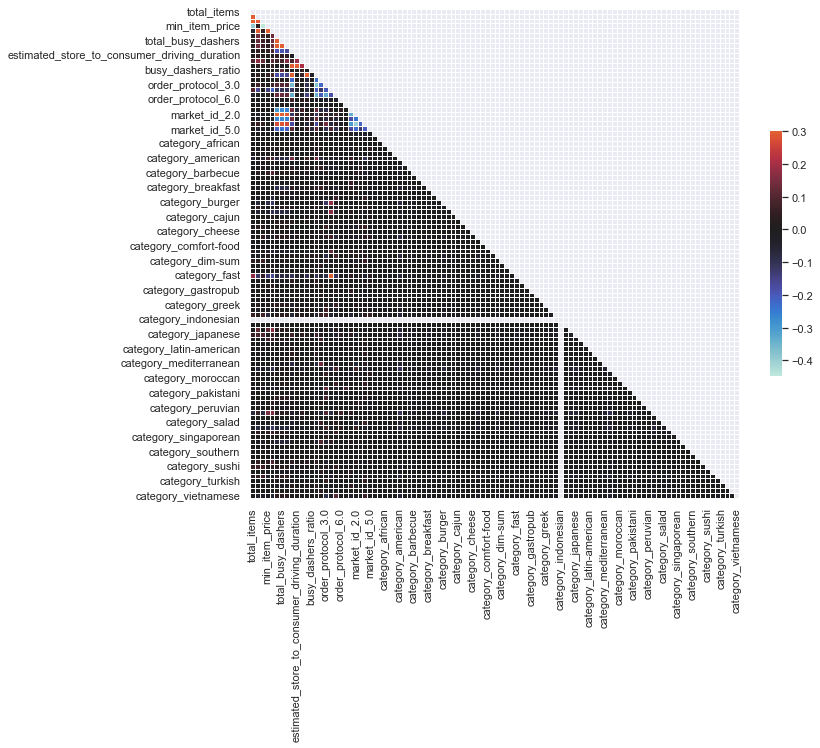

In [189]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)
# to have a better visualization, we will take only one triangle 
# because other trangle is only its symmetry (i.e a x b and b x a)

# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("icefire", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [190]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [191]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

* ```total_onshift_dashers``` and ```total_busy_dashers``` appear to be redundant as they are highly correlated. Since they are also represented by ```busy_dashers_ratio```, we wil drop these.
* ```estimated_store_to_consumer_driving_duration``` is highly correlated with ```estimated_non_prep_duration``` which we created. We will drop ```estimated_non_prep_duration``` and keep the remaining one.
* ```market_id_```s are correlated with each other, we will drop these as well.

In [192]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat market id dummies
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
train_df.shape

(177070, 90)

In [194]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [195]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

### Feature Engineering

In [197]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

In [198]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

In [199]:
train_df.shape

(177070, 82)

### Multicollinearity Check

In [200]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [201]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [202]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dashers_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210844
79,estimated_order_place_duration,13.472279


In [203]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000369
2,category_belgian,1.000461
3,category_russian,1.002022
4,category_gluten-free,1.002372
...,...,...
75,category_american,4.505928
76,avg_price_per_item,5.958972
77,busy_dashers_ratio,6.357889
78,estimated_store_to_consumer_driving_duration,7.192644


### Feature Selection

In [204]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

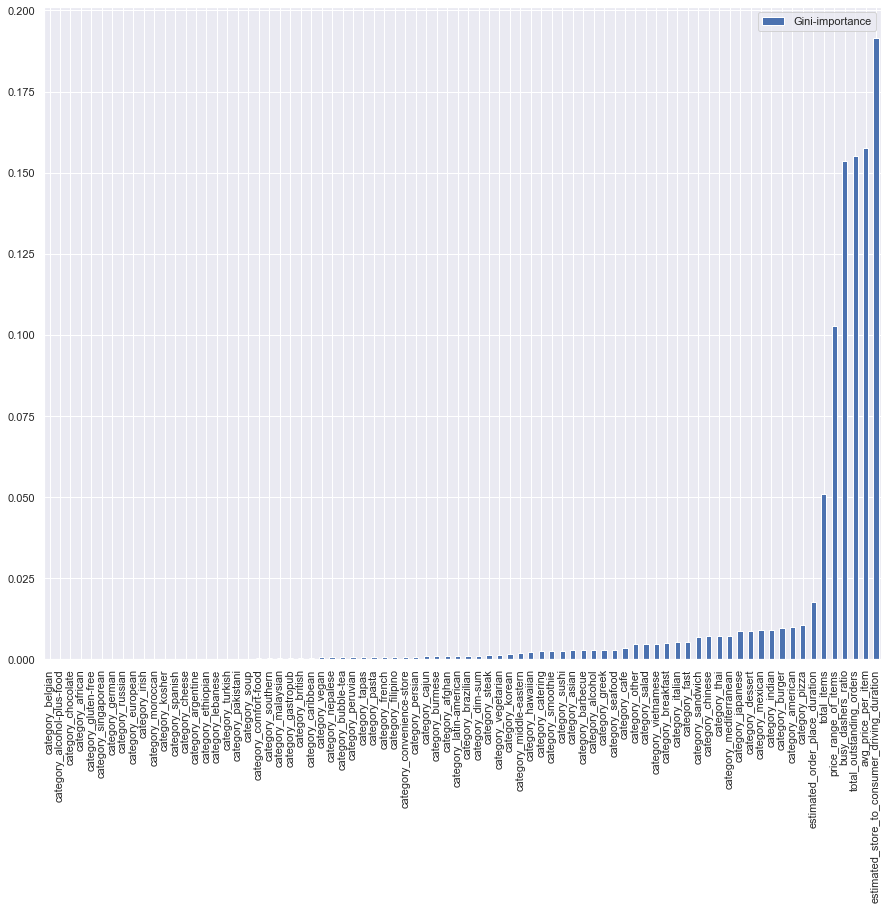

In [205]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

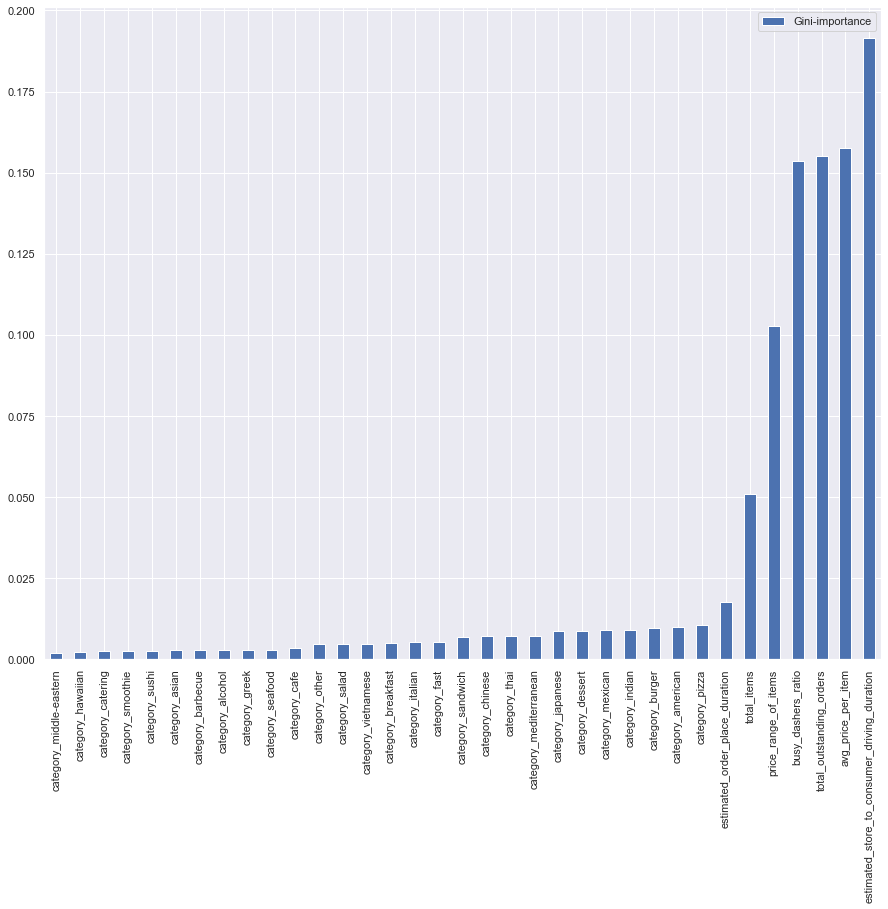

In [206]:
# check the most important ones
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [207]:
# we can obtain the column names as next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

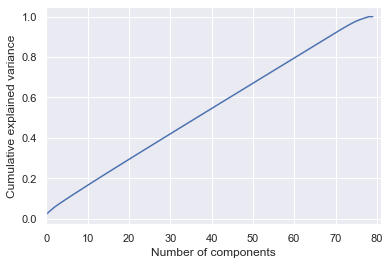

In [208]:
# apply PCA to see feature contributions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Apply Scaler

In [209]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [210]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [211]:
# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

##### Inverse Transform for Metric Comparison

In [212]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

### Classical Machine Learning

In [213]:
# create a generic function which can work with multiple machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [215]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}


regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 

    
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

# examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2047.8220420710836 in RandomForest
Error = 2036.2498779296875 in XGBoost
Error = 2033.4355809987908 in LGBM
Error = 2037.057373046875 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2048.0780570496518 in RandomForest
Error = 2036.561279296875 in XGBoost
Error = 2034.4499976619875 in LGBM
Error = 2152.13623046875 in MLP
-----scaled with NotScale-------- included columns are full dataset

Train error = 1071.4970703125 in Ridge
Test error = 2053.692626953125 in Ridge


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.42528e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 397.47545248115347 in RandomForest
Test error = 2048.030049920667 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1055.9566650390625 in MLP
Test error = 2049.1806640625 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2048.5821584611986 in RandomForest
Error = 2035.453369140625 in XGBoost
Error = 2034.6538984910121 in LGBM
Error = 2036.124267578125 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2048.1463380354785 in RandomForest
Error = 2036.3470458984375 in XGBoost
Error = 2035.196536738781 in LGBM
Error = 2142.812744140625 in MLP
-----scaled with NotScale-------- included columns are selected_features_40

Train error = 1072.35498046875 in Ridge
Test error = 2054.00439453125 in Ridge


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 396.80497660849977 in RandomForest
Test error = 2048.8200471913287 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1055.5792236328125 in MLP
Test error = 2047.0303955078125 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2048.438424994047 in RandomForest
Error = 2037.6336669921875 in XGBoost
Error = 2036.0233846729805 in LGBM
Error = 2036.849365234375 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2047.456976182886 in RandomForest
Error = 2037.1251220703125 in XGBoost
Error = 2035.581516471472 in LGBM
Error = 2161.9658203125 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train error = 1074.506591796875 in Ridge
Test error = 2055.36572265625 in Ridge


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 399.88341623447286 in RandomForest
Test error = 2048.5789366836725 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1061.9473876953125 in MLP
Test error = 2052.04541015625 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2051.48788626557 in RandomForest
Error = 2040.27001953125 in XGBoost
Error = 2038.1313604554389 in LGBM
Error = 2040.304443359375 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.882080078125 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2051.921097712685 in RandomForest
Error = 2039.672119140625 in XGBoost
Error = 2037.6564489201091 in LGBM
Error = 2091.837646484375 in MLP
-----scaled with NotScale-------- included columns are selected_features_10

Train error = 1076.7279052734375 in Ridge
Test error = 2056.568359375 in Ridge
Train error = 1069.2324011708552 in DecisionTree
Test error = 2054.597176140608 in DecisionTree
Train error = 397.8079436318926 in RandomForest
Test error =

c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [216]:
pred_df = pd.DataFrame(pred_dict)

In [217]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698730
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2047.822042
3,XGBoost,full dataset,Standard scaler,2036.249878
4,LGBM,full dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2091.837646
68,RandomForest,selected_features_10,NotScale,2091.837646
69,XGBoost,selected_features_10,NotScale,2091.837646
70,LGBM,selected_features_10,NotScale,2091.837646


<AxesSubplot:>

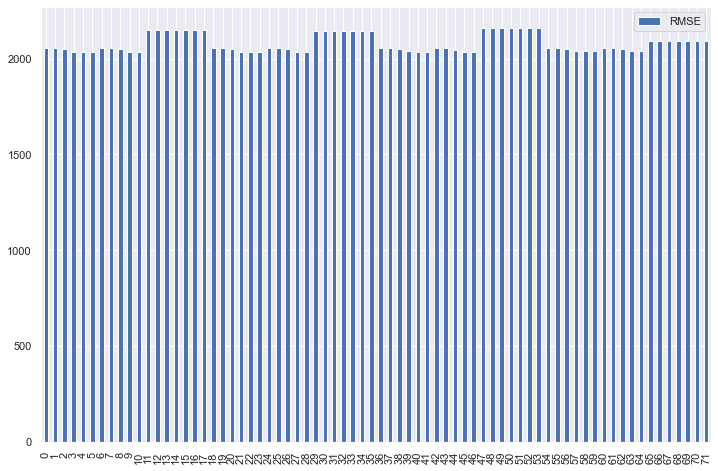

In [218]:
pred_df.plot(kind='bar', figsize=(12,8))

In [219]:
# change the problem a bit
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2055.407470703125 in Ridge
Error = 2063.3402827182467 in DecisionTree
Error = 2053.6451084911846 in RandomForest
Error = 2037.8203125 in XGBoost
Error = 2035.7236370573405 in LGBM
Error = 2038.230224609375 in MLP


In [220]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

# continue with best performing model
regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370573405 in LGBM


In [221]:
# choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

In [222]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [223]:
# sum predictions up with non preparation activities such as order placing and driving.
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [224]:
# check new error rate
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370573405

In [225]:
# What if we use another regression to obtain the actual total delivery duration?
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510303845
RMSE of: Ridge 986.6912510344928
RMSE of: DecisionTree 1235.578088153976
RMSE of: RandomForest 1308.4082562081485
RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.0261857783136


### Deep Learning

In [227]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [228]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 1s 679us/step - loss: 1.1475 - root_mean_squared_error: 1.0712
Epoch 2/100
443/443 [==============================] - 0s 679us/step - loss: 1.1214 - root_mean_squared_error: 1.0590
Epoch 3/100
443/443 [==============================] - 0s 628us/step - loss: 1.1196 - root_mean_squared_error: 1.0581
Epoch 4/100
443/443 [==============================] - 0s 674us/step - loss: 1.1192 - root_mean_squared_error: 1.0579
Epoch 5/100
443/443 [==============================] - 0s 722us/step - loss: 1.1186 - root_mean_squared_error: 1.0577
Epoch 6/100
443/443 [==============================] - 0s 804us/step - loss: 1.1185 - root_mean_squared_error: 1.0576
Epoch 7/100
443/443 [==============================] - 0s 616us/step - loss: 1.1182 - root_mean_squared_error: 1.0574
Epoch 8/100
443/443 [==============================] - 0s 614us/step -

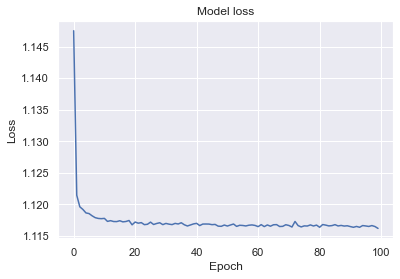

In [229]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

We achieved the same performance with the MLP method of sklearn. It could be possible to improve the performance a bit more with hyperparameter tuning in ANN, however, it requires considerable time and effort. Would it be a better approach when we already have a good performance Linear Regression model which is very simple and fast? It is a design choice. We leave our official solution as LGBM + Linear Regression on top.